In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC
import numpy as np
import matplotlib.pyplot as plt
import cv2
# import netCDF4 as nc

In [1]:

import os
os.getcwd()
path1 = 'E:\\SIF data\\FPAR_2016'
path2 = 'E:\\SIF data\\GOME_2016\\GOME_2016\\'
os.chdir('E:\\SIF data\\FPAR_2016')
%matplotlib inline

# cdl_data = np.load('labels.npy')

(-291629.61705008365, 3003882.4333905363)

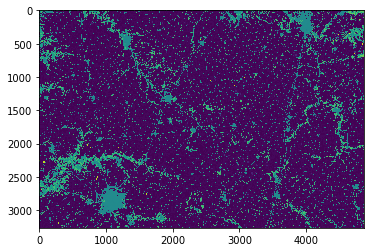

In [6]:
cdl_data = np.load('label2s.npy')
plt.imshow(cdl_data)


import my_functions
my_functions.getCDLprojection(-100,50)
# plt.hist(cdl_data)
# x = np.array([1,2,3])
# y = np.array([3,4,5])
# plt.plot(x,y)

In [4]:
cdl_data.shape

#shape[0] is latitude
#shape[1] is longitude

(3264, 4870)

In [21]:
# data = DBF('mydata.tif.vat.dbf')
from dbfread import DBF
data = DBF('CDL_2016_clip_20180209010216_40491170.tif.vat.dbf')

In [19]:
app = []
for i in data:    
    if i['CLASS_NAME'] != '':
        app.append([i['VALUE'], i['CLASS_NAME']])

In [32]:
#forest: 63
#grass: 176
#corn: 1
#soybean: 5

import my_functions
#test get inverse project function
#test four corners

print(my_functions.getInverseProj(556935,2049195))
#correct
print(my_functions.getInverseProj(556935+4870*30,2049195))
#correct
print(my_functions.getInverseProj(556935,2049195-3264*30))
#correct
print(my_functions.getInverseProj(556935+4870*30,2049195-3264*30))
#correct

# my_functions

def get_proportion(submat):
    row = np.array([0,0,0,0])
    for i in submat:
        for j in i:
            if j == 1:
                row[0] += 1
            elif j == 5:
                row[1] += 1
            elif j == 64:
                row[2] += 1
                
            elif j == 176:
                row[3] += 1
                
    if np.max(row) != 0:
        row = row/np.sum(row)
        
    return row
# app.append()

(-89.29439623403405, 41.27341489940353)
(-87.54363844886106, 41.169415367036144)
(-89.3764332424952, 40.4011629278052)
(-87.64689522256928, 40.29849844292236)


In [34]:
llon = 556935
rlon = llon + 4870*30
ulat = 2049195
blat = ulat - 3264*30
raw_data = SD('FPAR_A2016233.hdf', SDC.READ)

QC_reg_data = raw_data.select('FparExtra_QC')[:]
FPAR_reg_data = raw_data.select('Fpar_500m')[:]
mat = np.zeros((100,4))
rhs = np.zeros(100)

#make a 100*4 grid

cdl_i = 8
cdl_j = 8
#cdl_i represents the current latitude
#cdl_j represents the current longitude
ct = 0
for i in range(llon + 8*30, llon + 8100 + 8*30,810):
    #0,0,  27,0,   54,0,   
    #0,27,  27,27,   54,27
    cdl_i = 8
    for j in range(ulat - 8*30, ulat - 8100 -8*30, -810):
        #step size is 30  
        #calculate the latitude and longitude
        cur_lon, cur_lat = my_functions.getInverseProj(i,j)
        #project it to the modis pixel
        fp_lon_ind, fp_lat_ind = my_functions.coords_to_ind(cur_lon, cur_lat)
        #find the qc value according to the modis pixel
        qc = QC_reg_data[fp_lat_ind, fp_lon_ind]
        #if qc value is good then we append it to our regression training sample
        
        print(cdl_i, cdl_j)
        print(cur_lat, cur_lon)
        if my_functions.get_cloud(qc)[0] == '0' and my_functions.get_cloud(qc)[1] == '0':
        
            rhs[ct] = FPAR_reg_data[fp_lat_ind, fp_lon_ind]
            
            mat[ct,:] = get_proportion(cdl_data[cdl_i-8: cdl_i+8, cdl_j-8: cdl_j+8])
  
            #increment next row by 1
            ct += 1
        
        #update the cdl box coordinates
        cdl_i += 27
    cdl_j += 27
        

8 8
41.271125159872014 -89.29171981419654
35 8
41.26390755653444 -89.29240700143797
62 8
41.25668999687637 -89.29309404813853
89 8
41.24947248076677 -89.29378095434126
116 8
41.242255008074686 -89.29446772008917
143 8
41.23503757866908 -89.29515434542532
170 8
41.22782019241909 -89.29584083039263
197 8
41.220602849193995 -89.29652717503409
224 8
41.213385548862846 -89.29721337939267
251 8
41.20616829129499 -89.29789944351127
8 35
41.270614458811146 -89.28200000313831
35 35
41.26339691105751 -89.28268817942693
62 35
41.25617940696273 -89.28337621497447
89 35
41.248961946395724 -89.28406410982399
116 35
41.241744529225436 -89.2847518640186
143 35
41.23452715532107 -89.28543947760134
170 35
41.227309824551725 -89.28612695061527
197 35
41.22009253678644 -89.28681428310341
224 35
41.212875291894626 -89.28750147510878
251 35
41.20565808974541 -89.28818852667438
8 62
41.27010301979385 -89.27228033286428
35 62
41.26288552770307 -89.272969498157
62 62
41.255668079250334 -89.27365852250841
89 62

In [36]:
from numpy.linalg import lstsq

result = lstsq(mat, rhs)
print(result)

(array([ 83.50280861,  86.10463247,   0.        ,  75.35127649]), array([], dtype=float64), 3, array([ 7.07607641,  3.63228615,  1.80871845,  0.        ]))


In [9]:
def run_regression(query, slon, slat):
    
    raw_data = SD(query, SDC.READ)
    QC_reg_data = raw_data.select('FparExtra_QC')[:]
    FPAR_reg_data = raw_data.select('Fpar_500m')[:]
    mat = np.zeros((100,4))
    rhs = np.zeros(100)
    #make a 100*4 grid
    
    cdl_i = -(slat - ulat)//30
    #lat
    cdl_j = (slon - llon)//30
    print(cdl_i, cdl_j)
    #lon
    ct = 0
    
    print(cdl_i, cdl_j)
    for i in range(slon, slon + 8100,810):
        
        #set lat to the beginning lat
        cdl_i = -(slat - ulat)//30
        
        for j in range(slat, slat-8100, -810):
            
            #calculate the latitude and longitude
            cur_lon, cur_lat = my_functions.getInverseProj(i,j)
            #project it to the modis pixel
            fp_lon_ind, fp_lat_ind = my_functions.coords_to_ind(cur_lon, cur_lat)
            #find the qc value according to the modis pixel

            qc = QC_reg_data[fp_lat_ind, fp_lon_ind]
            #if qc value is good then we append it to our regression training sample

            if my_functions.get_cloud(qc)[0] == '0' and my_functions.get_cloud(qc)[1] == '0':

                rhs[ct] = FPAR_reg_data[fp_lat_ind, fp_lon_ind]
                
                mat[ct,:] = get_proportion(cdl_data[cdl_i: cdl_i+27, cdl_j: cdl_j+27])

                #increment next row by 1
                ct += 1
            cdl_i += 27
        cdl_j += 27
        
    result = lstsq(mat, rhs)
    return result[0]


In [19]:
def get_fpar_series():

    time_series = []

    prefix ='FPAR_A2016'
    suffix = '.hdf'

    print(prefix+suffix)
    
    for k in range(llon + 8100*3, llon + 8100*10, 8100):
        ts = []
        print(k)

        for i in range(1,361,8):
            a = str(int(i))
            if i < 10:
                a = '00'+ a
            elif i < 100:
                a = '0' + a

            query = prefix + a + suffix
            try:
                data = SD(query, SDC.READ)
                fpars = run_regression(query, k, ulat)
                ts.append(fpars)
#                 print(query)
        
        
            except:
                continue
        time_series.append(ts)
        print(ts)
            
    return time_series

In [11]:
time_series = get_fpar_series()

FPAR_A2016.hdf
556935
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
[array([ 14.17197978,  31.20705761,   0.        ,  31.5479377 ]), array([ 10.41021192,  12.84573322,   0.        ,  22.18105297]), array([ 12.02936158,  11.5338623 ,   0.        ,  35.8140887 ]), array([ 11.90158284,  16.45811337,   0.        ,  36.41002275]), array([ 14.99974189,  12.23581184,   0.        ,  44.51692489]), array([ 13.78216264,  12.85747963,   0.        ,  33.67902948]), array([ 15.59479154,  12.97833842,   0.        ,  27.11140189]), array([ 16.37255556,  16.36763803,   0.        ,  32.22546488]), array([ 19.34283876,  16.9858101 ,   0.        ,  36.62645805]), array([ 20.1460747 ,  19.44438876,   0. 

In [31]:
# r2 = run_regression('FPAR_A2016025.hdf',mat, llon + 8100, ulat - 8100)
# print(r2)

[  9.24943452  14.6470402    0.          17.79595574]


In [12]:
data = np.array(time_series)

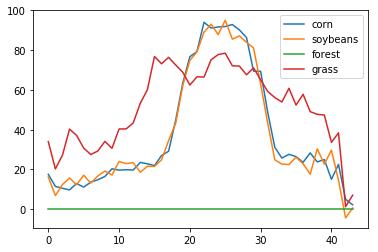

In [21]:
plt.plot(data[:,0], label = 'corn')
plt.plot(data[:,1], label = 'soybeans')
plt.plot(data[:,2], label = 'forest')
plt.plot(data[:,3], label = 'grass')
plt.legend()

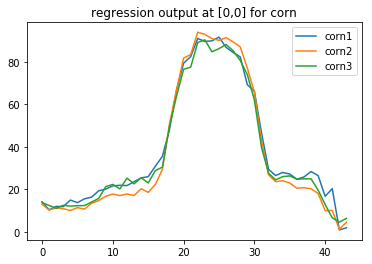

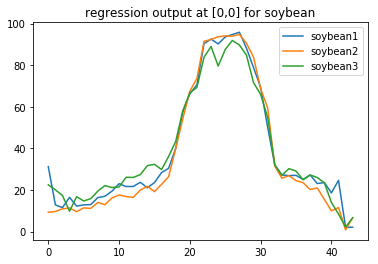

In [15]:
plt.plot(data[0, :, 0], label = 'corn1')
plt.plot(data[1, :, 0], label = 'corn2')
plt.plot(data[2, :, 0], label = 'corn3')
plt.legend()
plt.title('regression output at [0,0] for corn')
plt.figure()



plt.plot(data[0, :, 1], label = 'soybean1')
plt.plot(data[1, :, 1], label = 'soybean2')
plt.plot(data[2, :, 1], label = 'soybean3')
plt.legend()
plt.title('regression output at [0,0] for soybean')
plt.figure()


In [20]:
time_series2 = get_fpar_series()

FPAR_A2016.hdf
581235
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
0 810
[array([ 16.94217793,  19.93611878,   0.        ,  39.31371829]), array([ 12.12359845,  19.52102741,   0.        ,  29.3618655 ]), array([ 10.92187641,  19.25022107,   0.        ,  29.54891871]), array([ 14.4467642 ,  18.29743654,   0.        ,  35.94827378]), array([ 17.69907192,  16.19170937,   0.        ,  32.04294088]), array([ 11.53315078,  12.11436074,   0.        ,  22.2900628 ]), array([ 15.67366919,  15.75160392,   0.        ,  23.324677

In [21]:
t2 = np.array(time_series2)

In [24]:
final_t = np.concatenate((time_series,t2), axis = 0)

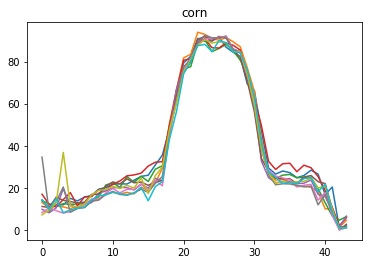

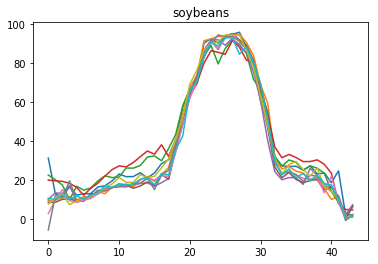

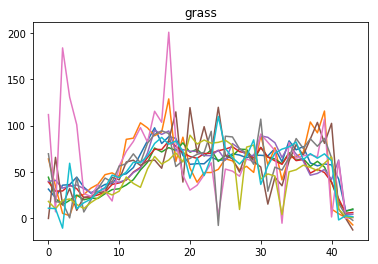

In [44]:

for i in range(10):
    plt.plot(final_t[i, :, 0])
    
plt.title('corn')
plt.figure()


for i in range(10):
    plt.plot(final_t[i, :, 1])
plt.title('soybeans')
plt.figure()


for i in range(10):
    plt.plot(final_t[i, :, 3])

plt.title('grass')
plt.figure()


In [37]:
final_t

array([[[ 14.17197978,  31.20705761,   0.        ,  31.5479377 ],
        [ 10.41021192,  12.84573322,   0.        ,  22.18105297],
        [ 12.02936158,  11.5338623 ,   0.        ,  35.8140887 ],
        ..., 
        [ 20.39482941,  24.65129527,   0.        ,  42.45718452],
        [  0.95237358,   2.01149732,   0.        ,   8.18676908],
        [  1.94010591,   2.12383448,   0.        ,   9.3825556 ]],

       [[ 13.04685011,   9.29266691,   0.        ,  64.07174243],
        [ 10.28049404,   9.66774417,   0.        ,  34.67210509],
        [ 11.36399078,  10.92428503,   0.        ,   5.43132425],
        ..., 
        [ 10.11824879,  11.54978342,   0.        ,   5.11044245],
        [  1.28277343,   0.8092723 ,   0.        ,   0.85204983],
        [  4.5853852 ,   6.6659136 ,   0.        ,  -7.04077639]],

       [[ 13.78411659,  22.48532227,   0.        ,  44.35975137],
        [ 12.46113177,  20.09127017,   0.        ,  21.4193245 ],
        [ 11.08329168,  17.370247  ,   0.   

(array([  1.33270540e+07,   6.20260000e+04,   7.98500000e+03,
          0.00000000e+00,   1.31578700e+06,   5.35161000e+05,
          6.09072000e+05,   3.26400000e+04,   8.28000000e+02,
          5.12700000e+03]),
 array([   0. ,   25.4,   50.8,   76.2,  101.6,  127. ,  152.4,  177.8,
         203.2,  228.6,  254. ]),
 <a list of 10 Patch objects>)

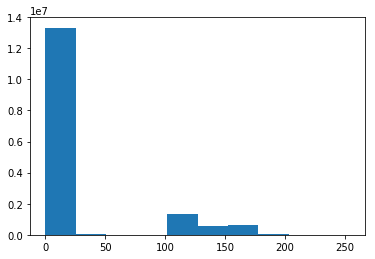